In [1]:
import sys
import cv2
import math
import skimage.color
import numpy as np
import heapq as hq
import matplotlib.pyplot as plt

from skimage.segmentation import mark_boundaries
from PIL import Image

%matplotlib inline

In [2]:
# helper function to plot the image with no axis and custom title
def plot(image, title="title", savefig=False):
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    if savefig == True:
        # convert image to RGB, then write
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite("output/problem3/" + title + ".png", image)

In [3]:
# function to add black borders to the segmented image
def add_borders(image):
    # create a copy
    image_with_borders = image.copy()
    # variable that stores the color of the border (black)
    black_border = [0, 0, 0]
    
    # loop through each image
    # we want those pixels who have different colors to create a black border
    for row in range(image.shape[0] - 1):
        for col in range(image.shape[1] - 1):
            # edge case
            if row == 0 or col == 0:
                continue
            else:
                for i in range(-1, 1):
                    for j in range(-1, 1):
                        if ((image[row][col][0] == image[row+i][col+j][0]) and 
                            (image[row][col][1] == image[row+i][col+j][1]) and 
                            (image[row][col][2] == image[row+i][col+j][2])):
                            continue
                        else:
                            image_with_borders[row][col] = black_border

    return image_with_borders

# SNIC (Simple Non-Iterative Clustering)

In [4]:
# load images from assignment3 and assignment4
test_images = ["images/wt_slic.png",
              "images/white-tower.png",
              "images/uttower_left.jpg",
              "images/uttower_right.jpg"]

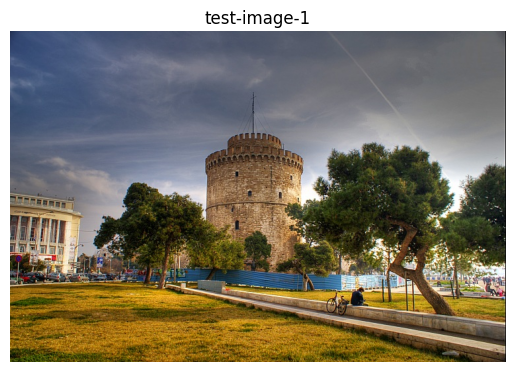

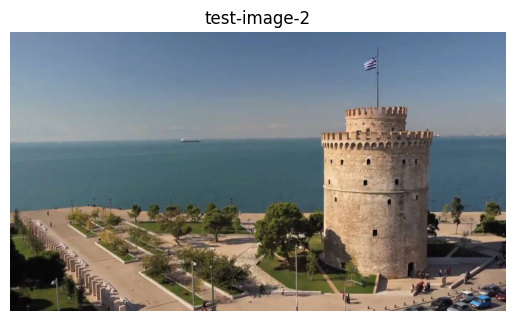

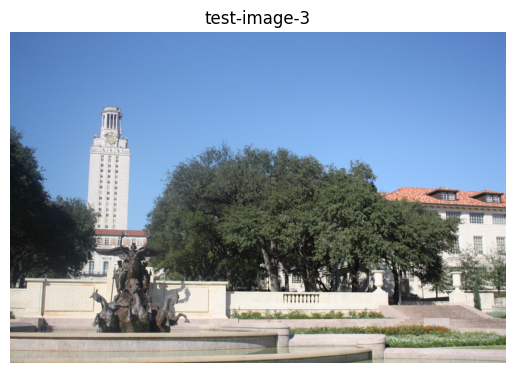

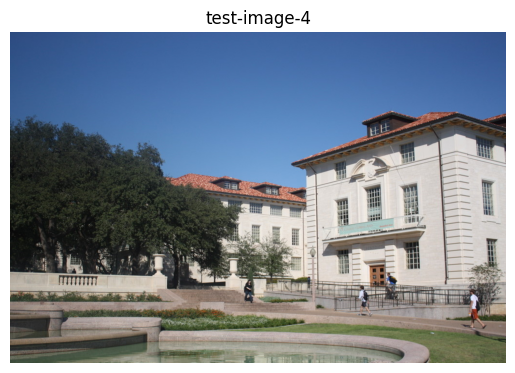

In [5]:
for num, file in enumerate(test_images):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plot(image, title="test-image-" + str(num+1), savefig=False)

In [6]:
# create a Queue
class Queue(object):
    def __init__(self, _buffer_size=0):
        self.heap = []
        self._sub_idx = 0

    def enqueue(self, priority, value):
        hq.heappush(self.heap, (priority, self._sub_idx, value))
        self._sub_idx += 1
    
    def dequeue(self):
        return hq.heappop(self.heap)

    def isEmpty(self):
        return len(self.heap) == 0
    
    def size(self):
        return len(self.heap)

In [7]:
# get pixels (neighbors) that are 4-distance away
def get_neighbors(point, img_shape):
    count = 0
    neighbors = [None, None, None, None]

    x_coord = point[0]
    y_coord = point[1]

    if x_coord - 1 >= 0:
        neighbors[0] = [x_coord - 1, y_coord]
        count += 1

    if y_coord - 1 >= 0:
        neighbors[count] = [x_coord, y_coord - 1]
        count += 1

    if x_coord + 1 < img_shape[1]:
        neighbors[count] = [x_coord + 1, y_coord]
        count += 1

    if y_coord + 1 < img_shape[0]:
        neighbors[count] = [x_coord, y_coord + 1]
        count += 1

    return neighbors, count

In [8]:
def get_grid_size(img_shape, num_pixels):
    im_y = float(img_shape[0])
    im_x = float(img_shape[1])

    # compute grid size
    ratio = im_x / im_y
    sqrt_px = sqrt(num_pixels)

    # can change
    grid_size = [int(max(1.0, sqrt_px * ratio) + 1), int(max(1.0, sqrt_px / ratio) + 1)]

    # create grid
    f = [im_x / float(grid_size[0]), im_y / float(grid_size[1])]
    h = [f[0] / 2.0, f[1] / 2.0]
    grid = [[[int(h[0] + x * f[0]), int(h[1] + y * f[1])] 
             for x in range(grid_size[0])] for y in range(grid_size[1])]
    return grid

In [9]:
# linear interpolation on vector 1 and 2 with t as point on that scale
# reference
# https://gist.github.com/laundmo/b224b1f4c8ef6ca5fe47e132c8deab56
def linear_ip_2d(vec1, vec2, t):
    a = (vec1[0] * (1 - t)) + (vec2[0] * t)
    b = (vec1[1] * (1 - t)) + (vec2[1] * t)
    return [a, b]


def linear_ip_3d(vec1, vec2, t):
    a = (vec1[0] * (1 - t)) + (vec2[0] * t)
    b = (vec1[1] * (1 - t)) + (vec2[1] * t)
    c = (vec1[2] * (1 - t)) + (vec2[2] * t)
    return [a, b, c]

In [10]:
# square norm of 2d points and 3d vectors
def square2_norm(a, b):
    return a**2 + b**2

def square3_norm(vec1, vec2):
    a = vec1[0] - vec2[0]
    b = vec1[1] - vec2[1]
    c = vec1[2] - vec2[2]
    return a**2 + b**2 + c**2

In [11]:
# SNIC distance measure
# get distance of kth superpixel centroid to jth candidate pixel
# Section 3.1 of paper
def distance_measure(x_coord, y_coord, x_color, y_color, s, m):
    # get distance measure using spatial and color distances
    # Section 3.1 equation 1
    spatial_distance = square2_norm(y_coord[0] - x_coord[0], y_coord[1] - x_coord[1]) * s
    color_distance = square3_norm(x_color, y_color) * m
    
    distance = spatial_distance + color_distance
    
    return distance

In [12]:
def get_distance_from_normalization_factors(image_size, number_of_superpixels, compactness):
    # compute normalization factors
    s_ = 1 / math.sqrt((image_size[0] * image_size[1]) / number_of_superpixels)
    m_ = 1 / float(compactness)

    def get_distance(x_coord, y_coord, x_color, y_color, s=s_, m=m_):
        return distance_measure(x_coord, y_coord, x_color, y_color, s, m)
    return get_distance

In [13]:
# main SNIC function
def SNIC(ip_img, points, compactness_factor):
    # create copy for output
    out_img = ip_img.copy()
    
    # input image dimensions
    dim1 = len(ip_img)
    dim2 = len(ip_img[0])
    
    img_shape = [dim1, dim2]
    
    # initialize label map and distance map
    # that store labels and distances respectively
    # SNIC algorithm says initialize it with 0 but gives division error
    # so initialized label map to -1 at the start
    label_map = [[-1] * img_shape[1] for _ in range(img_shape[0])]
    distance_map = [[sys.float_info.max] * img_shape[1] for _ in range(img_shape[0])]
    
    points = [point for im in get_grid_size(img_shape, points) for point in im]

    superpixel_points = len(points)

    image_distance = get_distance_from_normalization_factors(img_shape, superpixel_points, compactness_factor)

    # initialize centroids that store position, color and number of pixels
    centroids = [[point, ip_img[point[1]][point[0]], 0] for point in points]

    # initialize priority queue
    queue = Queue(img_shape[0] * img_shape[1] * 4)
    
    enqueue = queue.enqueue
    dequeue = queue.dequeue
    
    # loop through all superpixel points and fill into priority queue
    for sp in range(superpixel_points):
        centroid = centroids[sp]
        
        # get queue size
        lenq = -queue.size()
        enqueue(lenq, [centroid[0], centroid[1], sp])
        distance_map[centroid[0][1]][centroid[0][0]] = lenq

    is_empty = queue.isEmpty
    
    # while Q is not empty do
    while not is_empty():
        # dequeue the pixel, get the point and its coordinates
        px = dequeue()
        px_dist = px[0]
        point = px[2]
        point_coords = point[0]
        
        # if L[x_i] is 0
        # test if pixel is not already labeled
        # if label_map[point_coords[1] * im_width + point_coords[0]] == -1:
        # assign idx to that point, this will be index of centroid
        if label_map[point_coords[1]][point_coords[0]] == -1:
            idx = point[2]

            # label new pixel and get distance
            label_map[point_coords[1]][point_coords[0]] = idx
            distance_map[point_coords[1]][point_coords[0]] = px_dist

            # centroid update
            c = centroids[idx]
            px_count = c[2] + 1

            # get linear interpolation ratio
            ratio = 1 / px_count

            # adjust centroid position, color and number of pixels
            c[0] = linear_ip_2d(c[0], point_coords, ratio)
            c[1] = linear_ip_3d(c[1], point[1], ratio)
            c[2] = px_count

            neighbors, count = get_neighbors(point_coords, img_shape)
            for i in range(count):
                # get neighbor coordinates and check if already labelled
                nb_coords = neighbors[i]

                nb_x = nb_coords[0]
                nb_y = nb_coords[1]

                if label_map[nb_y][nb_x] == -1:
                    # get color of neighbor
                    nb_color = ip_img[nb_y][nb_x]
                    nb = [nb_coords, nb_color, idx]

                    # calculate distance of neighbor
                    nb_dist = image_distance(nb_coords, c[0], nb_color, c[1])

                    # condition to check if there is another point with a lower distance
                    # is not registered with this pixel
                    if distance_map[nb_y][nb_x] >= nb_dist:
                        distance_map[nb_y][nb_x] = nb_dist
                        enqueue(nb_dist, nb)
    
    # get segmented image from SNIC
    labels = np.array(label_map)

    # generate segment mask
    mask = [labels == i for i in range(len(centroids))]
    
    # get pixels for each segment
    vec = [out_img[mask[i], :] for i in range(len(centroids))]

    # loop over all centroids
    for i in range(len(centroids)):
        # get the average value and update out_img
        mean = np.mean(vec[i], 0)
        
        out_img[mask[i], :] = mean
        
    return out_img

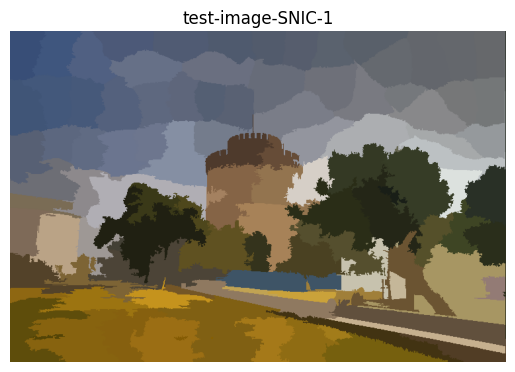

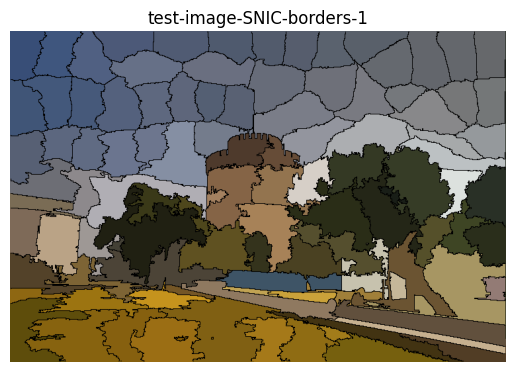

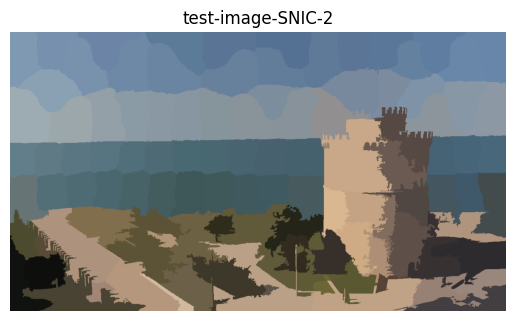

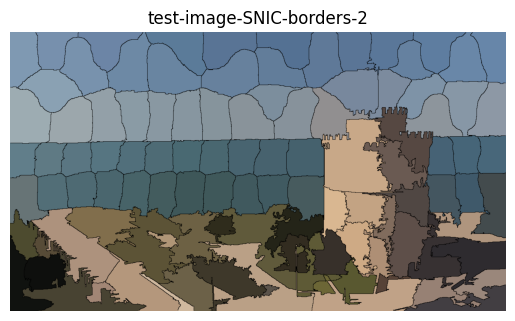

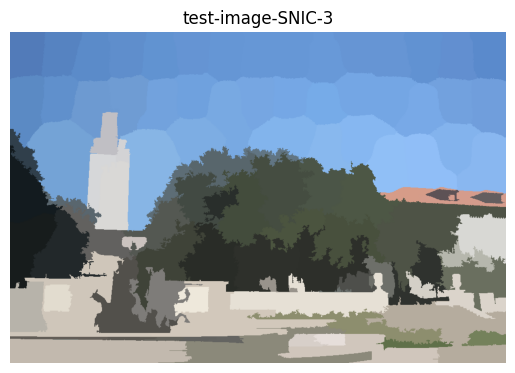

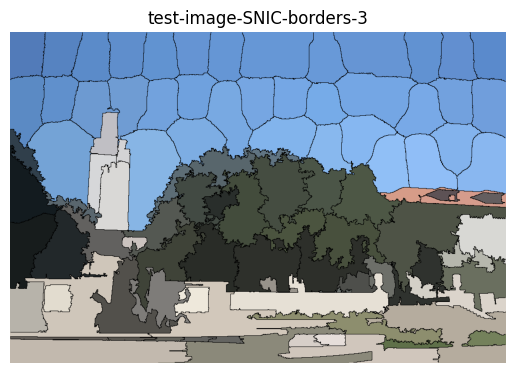

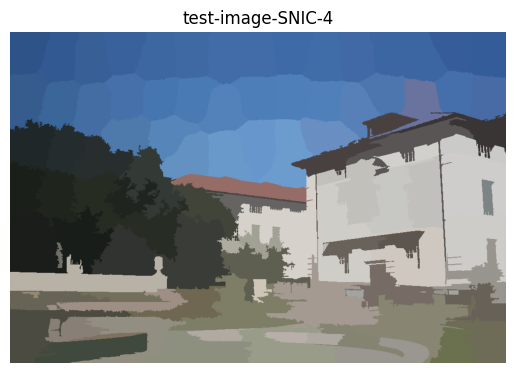

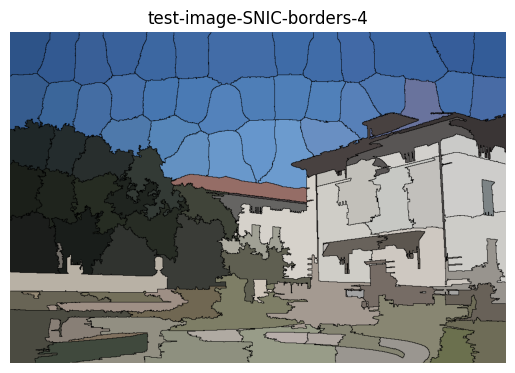

In [14]:
for num, file in enumerate(test_images):
    image = cv2.imread(file)
    
    #convert image to LAB for SNIC
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # implement SNIC
    image_snic = SNIC(image, points=100, compactness_factor=10)
    image_snic = cv2.cvtColor(image_snic, cv2.COLOR_LAB2RGB)
    
    # add borders
    image_snic_borders = add_borders(image_snic)
    
    # plot both
    plot(image_snic, title="test-image-SNIC-" + str(num+1), savefig=True)
    plot(image_snic_borders, title="test-image-SNIC-borders-" + str(num+1), savefig=True)